Can you predict whether or not an NBA player will last at least 5 years in the league based only on their rookie season?

In [1]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
import sklearn.pipeline as pl

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
#Read data
player_data = pd.read_csv('player_data.csv')
seasons_stats = pd.read_csv('Seasons_stats.csv')

In [3]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 8 columns):
name          4550 non-null object
year_start    4550 non-null int64
year_end      4550 non-null int64
position      4549 non-null object
height        4549 non-null object
weight        4544 non-null float64
birth_date    4519 non-null object
college       4248 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 284.5+ KB


Since the NBA has changed rapidly, particularly in increased reliance on 3pt shots,
we'll focus on the last eight seasons. Only rookie seasons from '06-'07 to '13-'14 will be considered. This is a logical break since the '06-'07 season was the first for which domestic players were not allowed to enter the draft directly out of high school.

In [31]:
#Note: year's are labeled by the year the season ends
start_year = 2007
end_year = 2015

modern_player_data = player_data[(player_data['year_start'] >= start_year) & (player_data['year_start'] < end_year)].copy()

modern_player_data.fillna('Overseas', inplace=True)
modern_player_data.rename(columns={"name":"Player"}, inplace=True)


In [5]:
#create new feature columns
def birth_str_to_int(s):
    return int(s.split()[2])

modern_player_data['Age'] = modern_player_data['year_start'] - modern_player_data['birth_date'].apply(lambda s: birth_str_to_int(s))

#tenure column assumes player didn't leave NBA between their first and last year.
modern_player_data['Tenure'] = modern_player_data['year_end'] - modern_player_data['year_start'] + 1

In [6]:
seasons_stats.drop(['Unnamed: 0', 'blanl', 'blank2', 'Age'], axis=1, inplace=True)
seasons_stats.head()

,Year,Player,Pos,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [7]:
#Pick out rookie seasons in seasons stats df
IDList = list(seasons_stats.groupby('Player')['Year'].idxmin(axis=1))

rookie_seasons_stats = seasons_stats.iloc[IDList].copy()

#remove rookie seasons before 2008
rookie_seasons_stats = rookie_seasons_stats[(rookie_seasons_stats['Year'] >= start_year) & (rookie_seasons_stats['Year'] < end_year)].copy()
rookie_seasons_stats.dropna(subset = ['Year'], inplace=True)
rookie_seasons_stats['Year'] = rookie_seasons_stats['Year'].astype(int)

In [8]:
#Cleaning
rookie_seasons_stats.dropna(axis=0, inplace=True, subset=['TS%', 'TOV%', 'eFG%', '2P%'])

#Remaining nulls are due to division by 0 in FT%, 3P% categories
rookie_seasons_stats.fillna(value=0.0, inplace=True)

rookie_seasons_stats.reset_index(drop=True, inplace=True)

In [9]:
#Merge personal player stats df and rookie season on-court stats df
rookies_df = pd.merge(modern_player_data, rookie_seasons_stats, how = 'inner', on = ['Player'])

rookies_df['Pos'].unique()
#['PF' 'SG' 'C' 'PG' 'SF' 'SG-PG' 'PG-SG' 'PF-SF' 'SG-SF']

#Lets turn the position feature into a binary categorical variable, roughly separating 'guards' and 'bigs'. C, PF = 1. PG, SG, SF = 0.
rookies_df['POS'] = [1 if x == 'C' or x =='PF' or x =='PF-SF' else 0 for x in rookies_df['Pos']]
rookies_df.drop(['year_start', 'position', 'birth_date', 'year_end', 'Year', 'Tm', 'Pos', 'height', 'Player'], axis=1, inplace=True)

In [10]:
#We now have a single database on player rookie seasons from the last decade

#Must construct a target feature
rookies_df['TARGET'] = [1 if x >= 5 else 0 for x in rookies_df['Tenure']]

#Turn college into a categorical variable?
rookies_df['College_US'] = [0 if x == 'Overseas' else 1 for x in rookies_df['college']]
rookies_df.drop(['college','Tenure'], axis=1, inplace=True)

In [11]:
rookies_df.head()

,weight,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,POS,TARGET,College_US
0,240.0,23,29.0,0.0,342.0,15.9,0.632,0.027,0.507,10.3,16.6,13.4,5.2,2.0,3.5,15.6,14.7,0.7,0.4,1.1,0.157,-0.6,1.3,0.7,0.2,42.0,75.0,0.560,1.0,2.0,0.500,41.0,73.0,0.562,0.567,31.0,38.0,0.816,30.0,47.0,77.0,11.0,13.0,15.0,17.0,53.0,116.0,1,1,1
1,220.0,23,61.0,8.0,495.0,13.0,0.577,0.007,0.267,8.4,9.9,9.2,4.5,1.8,0.6,12.7,16.3,0.5,0.5,1.0,0.095,-2.4,-1.2,-3.6,-0.2,75.0,135.0,0.556,0.0,1.0,0.000,75.0,134.0,0.560,0.556,24.0,36.0,0.667,35.0,42.0,77.0,13.0,17.0,4.0,22.0,47.0,174.0,0,0,1
2,255.0,21,81.0,20.0,1197.0,11.2,0.541,0.000,0.735,14.1,17.1,15.6,4.9,1.7,3.9,22.5,11.7,0.9,1.9,2.9,0.114,-2.1,2.4,0.3,0.7,93.0,185.0,0.503,0.0,0.0,0.000,93.0,185.0,0.503,0.503,79.0,136.0,0.581,142.0,190.0,332.0,43.0,40.0,57.0,71.0,203.0,265.0,1,1,1
3,245.0,25,23.0,0.0,196.0,11.3,0.457,0.000,0.352,13.0,20.7,16.8,7.3,1.0,1.9,12.6,16.1,0.1,0.1,0.2,0.051,-3.9,-1.2,-5.1,-0.2,23.0,54.0,0.426,0.0,0.0,0.000,23.0,54.0,0.426,0.426,11.0,19.0,0.579,23.0,35.0,58.0,10.0,4.0,5.0,9.0,28.0,57.0,1,1,1
4,210.0,23,75.0,9.0,970.0,10.2,0.494,0.199,0.361,4.4,12.5,8.4,8.1,1.8,0.7,10.9,15.2,0.5,1.4,1.9,0.092,-2.3,0.6,-1.6,0.1,99.0,241.0,0.411,10.0,48.0,0.208,89.0,193.0,0.461,0.432,68.0,87.0,0.782,36.0,101.0,137.0,52.0,31.0,8.0,34.0,83.0,276.0,0,1,1


Exploratory Data Analysis

In [12]:
rookies_df.corr()['TARGET'].sort_values()

Age          -0.381323
TOV%         -0.058530
3PAr         -0.044938
STL%         -0.025617
ORB%          0.010811
POS           0.034914
AST%          0.036422
College_US    0.042442
weight        0.043546
USG%          0.046807
FTr           0.076587
TRB%          0.085219
3P%           0.110365
BLK%          0.117797
DRB%          0.152224
2P%           0.186804
FG%           0.222568
VORP          0.223802
DBPM          0.224095
eFG%          0.232381
3PA           0.239081
3P            0.239104
PER           0.246782
FT%           0.255249
TS%           0.257919
WS/48         0.263156
OBPM          0.270744
AST           0.276379
OWS           0.327333
BPM           0.332651
GS            0.333471
BLK           0.372408
TOV           0.383669
STL           0.394525
ORB           0.406330
FT            0.409705
FTA           0.416124
FGA           0.417772
2PA           0.426550
PTS           0.431438
DWS           0.433770
FG            0.434458
2P            0.435025
WS         

Age as well as OWS, BPM, DWS, WS and numerous stats that are correlated with total time on the court are important. For example it's no coincidence personal fouls (PF) are sandwiched between games (G) and minutes played (MP). The more time spent on the court, the more fouls a player will commit. We'll likely need to deal with this correlation between features, but initially we can test a random forest model.

In [32]:
#Base model
X = rookies_df.drop(['TARGET'], axis=1)
y = rookies_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [33]:
print(classification_report(y_test, predictions)) 
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

          0       0.77      0.74      0.75        27
          1       0.77      0.79      0.78        29

avg / total       0.77      0.77      0.77        56

[[20  7]
 [ 6 23]]


We obtain around 77% accuracy in our classification for this particular train/test split. Can it be improved by optimizing hyperparameters?

In [ ]:
#RF optimized
cv = ShuffleSplit(n_splits = 10, test_size = 0.1)
param_grid = {'n_estimators': range(100, 1000, 100), 'max_depth': [10, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 10]}
grid = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, verbose = 3, cv = cv)
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)

In [35]:
grid.best_params_ 

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [36]:
print(classification_report(y_test, grid_predictions)) 
print(confusion_matrix(y_test, grid_predictions))

             precision    recall  f1-score   support

          0       0.78      0.78      0.78        27
          1       0.79      0.79      0.79        29

avg / total       0.79      0.79      0.79        56

[[21  6]
 [ 6 23]]


The optimized RF model only slightly improves on the base model for this particular train/test split. Lets find the average accuracy over many instances of both models to better compare the two.

In [39]:
#Create list of accuracy scores for both RF models
rf_scorelist = []
rf_grid_scorelist = []
for j in range (0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    predictions = rfc.predict(X_test)
    rf_scorelist.append(rfc.score(X_test, y_test))

    rfc_grid = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 400)
    rfc_grid.fit(X_train, y_train)
    rfc_grid_predictions = rfc_grid.predict(X_test)
    rf_grid_scorelist.append(rfc_grid.score(X_test, y_test))
    

In [23]:
#Function to visualize the results
def boxplot_vis(list1, list2, list1_descript_str, list2_descript_str):
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x = list1)
    plt.title(list1_descript_str)
    plt.xlabel('Classification accuracy score')

    plt.subplot(1, 2, 2)
    plt.title(list2_descript_str)
    sns.boxplot(x = list2, color = 'red')
    plt.xlabel('Classification accuracy score')

    print ("Mean %f and standard deviation %f for %s" % (
    np.mean(list2), np.std(list2), list2_descript_str))
    print ("Mean %f and standard deviation %f for %s" % (
    np.mean(list1),np.std(list1),list1_descript_str))
    

Mean 0.746071 and standard deviation 0.052281 for Optimized RF
Mean 0.714286 and standard deviation 0.054807 for Base RF


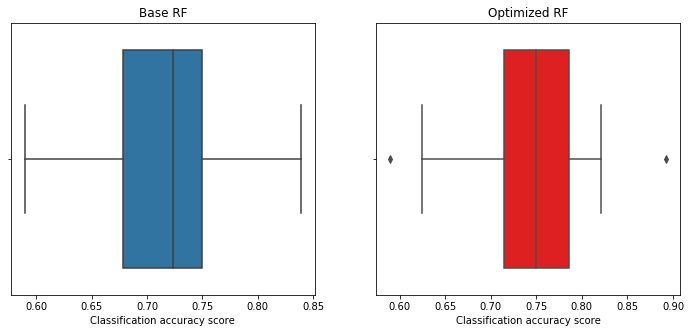

In [40]:
boxplot_vis(rf_scorelist, rf_grid_scorelist, 'Base RF', 'Optimized RF')

Improvement due to tweaking RF hyperparameters is about 3% for this dataset.


We can also look into feature selection and other classification methods. We'll first use a logistic regression model after performing PCA to reduce the dimensionality of the dataset. 

Then, I'll manually select some features that should be reflective of a player's chances of remaining in the league for at least five years, and perform logistic regression on this smaller set of features, comparing to the PCA case.

0    0.382358
1    0.153264
2    0.099227
3    0.043719
4    0.037992
5    0.032043
6    0.029500
7    0.024693
dtype: float64
Sum of first 8 components: 0.803


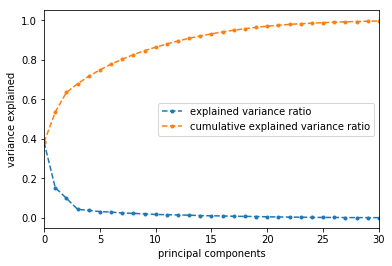

In [13]:
#PCA

#Scale data
scaler = StandardScaler()
scaler.fit(rookies_df.drop(['TARGET'], axis = 1))
scaled_features = scaler.transform(rookies_df.drop(['TARGET'], axis = 1))
scaled_df = pd.DataFrame(scaled_features, columns=rookies_df.columns[:-1])

#Perform PCA
pca = PCA()
pca_out = pca.fit(scaled_features)
pca_out_scaled = pd.DataFrame(pca.transform(scaled_features))
var_explained = pca_out.explained_variance_ratio_

#Visualize PCA
plt.plot(var_explained, '--.', label = 'explained variance ratio')
plt.plot(var_explained.cumsum(), '--.', label = 'cumulative explained variance ratio')
plt.xlim([0, 30])
plt.xlabel('principal components')
plt.ylabel('variance explained') 
plt.legend()

#Approximately 80% of variance is explained by 8 components.
print(pd.Series(var_explained).head(8))
print('Sum of first 8 components: {s:2.3f}'.format(s = sum(var_explained[0:8])))

In [14]:
#Logistic regression with stratified CV and PCA:

#Here n_components = 8.
#Changing to 18 (95% variance explained) does not improve the classification accuracy for this train/test split.
pca2 = PCA(n_components = 8)
logr = LogisticRegressionCV(penalty = 'l2')
pipeline = pl.Pipeline([('pca', pca2), ('logistic', logr)])

X = rookies_df.drop(['TARGET'], axis = 1)
y = rookies_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state = 0)

fit = pipeline.fit(X_train, y_train)
pcalog_pred = pipeline.predict(X_test)

In [15]:
print(classification_report(y_test, pcalog_pred)) 
print(confusion_matrix(y_test, pcalog_pred))

             precision    recall  f1-score   support

          0       0.73      0.81      0.77        27
          1       0.81      0.72      0.76        29

avg / total       0.77      0.77      0.77        56

[[22  5]
 [ 8 21]]


Now lets attempt to classify rookies with a set of manually selected features. 

Age and minutes played (MP) are both indicitive of a player's raw potential. A young player getting minutes suggests a team believes the player has raw talent worth developing. Points scored (PTS) and MP are obviously correlated, but PTS is more skill-related, so PTS will be kept over MP.

VORP, WS/48, and eFG%, are all stats measuring the effectiveness of a player, normalized by time on the court.

In [16]:
#Construct df with selected features
selected_rookies_df = rookies_df[['Age', 'PTS', 'VORP', 'WS/48', 'eFG%', 'TARGET']].copy()

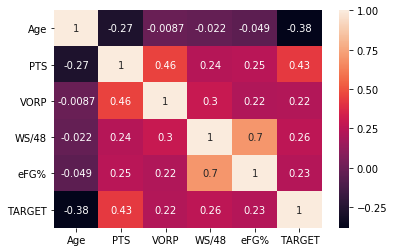

In [17]:
sns.heatmap(selected_rookies_df.corr(), annot = True)

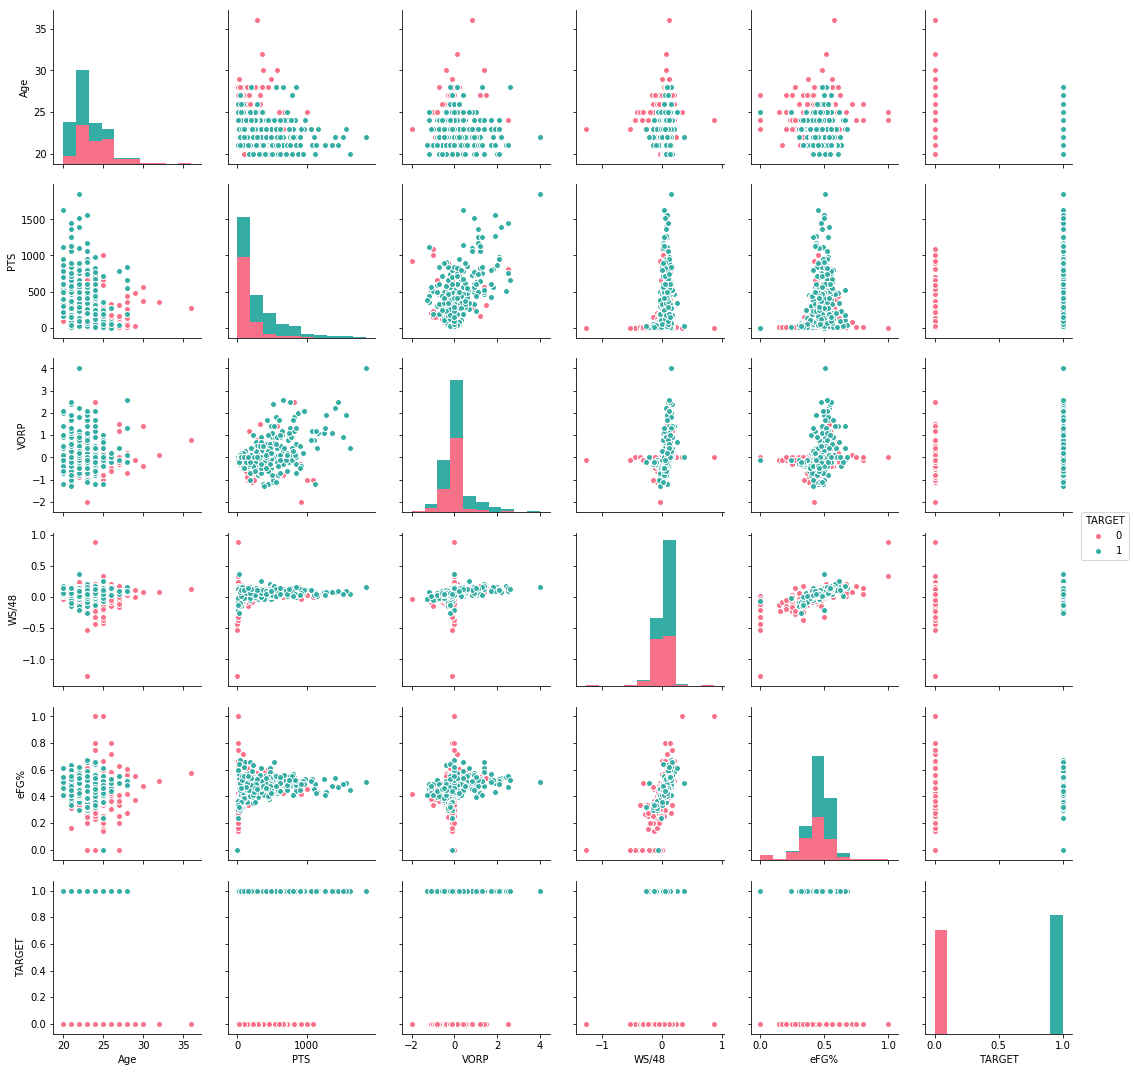

In [18]:
sns.pairplot(selected_rookies_df, hue = 'TARGET', palette = 'husl')

In [19]:
#Lets try Logistic regression with this feature set

log_reg = LogisticRegressionCV(penalty = 'l2')
X_s = selected_rookies_df.drop(['TARGET'], axis = 1)
y_s = selected_rookies_df['TARGET']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.1, random_state = 0)

fit_s = log_reg.fit(X_train_s, y_train_s)
log_reg_pred = log_reg.predict(X_test_s)

In [20]:
print(classification_report(y_test_s, log_reg_pred)) 
print(confusion_matrix(y_test, log_reg_pred))

             precision    recall  f1-score   support

          0       0.72      0.67      0.69        27
          1       0.71      0.76      0.73        29

avg / total       0.71      0.71      0.71        56

[[18  9]
 [ 7 22]]


We see logistic regression with the manually reduced dataset only misclassifies 3 more data points than the pca/logreg model for this particular train/test split. 

Lets find the average accuracy over many instances of both models to better compare the two.

In [29]:
selected_scorelist = []
pca_scorelist = []
for j in range (0, 100):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.1)

    fit_s = log_reg.fit(X_train_s, y_train_s)
    log_reg_pred = log_reg.predict(X_test_s)
    selected_scorelist.append(log_reg.score(X_test_s, y_test_s))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

    fit = pipeline.fit(X_train, y_train)
    pcalog_pred = pipeline.predict(X_test)
    pca_scorelist.append(pipeline.score(X_test, y_test))
    
    


Mean 0.737321 and standard deviation 0.057271 for manually selected features
Mean 0.691607 and standard deviation 0.053563 for pca selected features


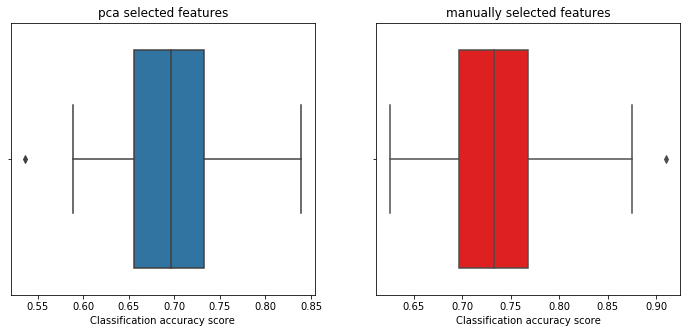

In [24]:
boxplot_vis(pca_scorelist, selected_scorelist, 'pca selected features', 'manually selected features')

The Random Forest and Logistic Regression models both successfully classify about 3/4 of the data for the year range '06-'07 to '13-'14. While the upper bound '13-'14 can't be increased (since it's been exactly five full seasons since '13-'14), the lower bound '06-'07 can be made earlier.

On one hand, a larger dataset may improve our prediction accuracy. On the other, the NBA has changed significantly over the years, so a model that utilizes data stretching over too many years may not be very predictive.

Lets alter the earliest season included and explore with logistic regression.

Going back to '99 - '00, the test set now has 101 datapoints.

Mean 0.742500 and standard deviation 0.053523 for manually selected features
Mean 0.696786 and standard deviation 0.052061 for pca selected features


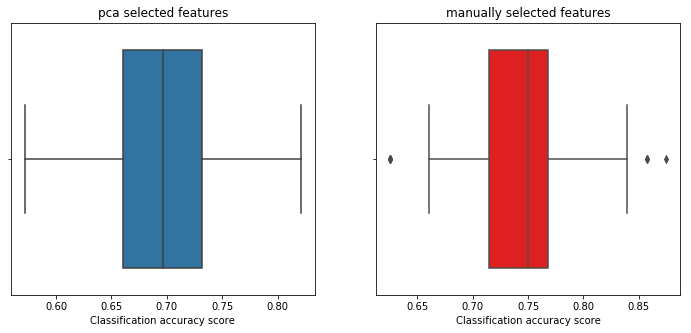

In [27]:
boxplot_vis(pca_scorelist, selected_scorelist, 'pca selected features', 'manually selected features')

Going back to '89 - '90, the test set now has 169 data points.

Mean 0.746607 and standard deviation 0.051736 for manually selected features
Mean 0.682143 and standard deviation 0.054222 for pca selected features


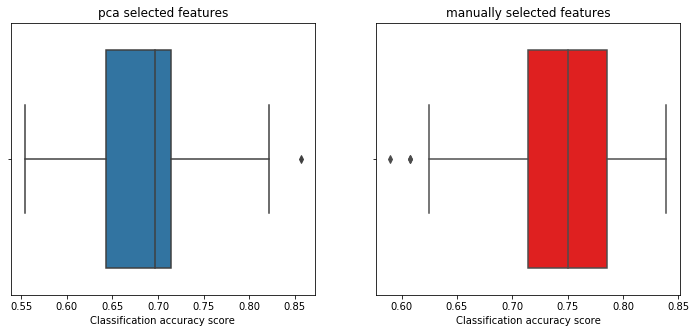

In [30]:
boxplot_vis(pca_scorelist, selected_scorelist, 'pca selected features', 'manually selected features')

The accuracy score of the logistic regression model with manually selected features only varies by a few percent between start_year = 1990, 2000, 2007. The tradeoff between predictive power and dataset size could be optimized by plotting score vs. start_year.